# Ensemble of Selection Functions
This notebook presents the analysis for DESI Imaging ELGs for ELGxCMB.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import fitsio as ft
from glob import glob
from scipy.stats import binned_statistic

# from getdist import plots, MCSamples

import sys
sys.path.append('/users/PHS0336/medirz90/github/LSSutils')
sys.path.append('/users/PHS0336/medirz90/github/sysnetdev')

from lssutils.dataviz import setup_color, mollview, mycolor, add_locators
from lssutils.stats.nnbar import get_meandensity, hist
from lssutils.stats.pcc import pcc
from lssutils.stats.cl import get_cl
from lssutils.extrn.corner import corner
import lssutils.utils as ut
from lssutils.lab import AnaFast

import sysnet.sources as src
from sysnet.sources.io import load_checkpoint, ImagingData, MyDataSet

In [2]:
%matplotlib inline

In [3]:
setup_color()

## Data cleaning
First, we would like to make sure that the data is cleaned.

In [4]:
def remove_islands(dt, nside=1024):
    # to remove islands in DECaLS N
    
    ra, dec = ut.hpix2radec(nside, dt['hpix'])
    is_good = dec > -11.0 # spurious islands
    
    return dt[is_good]    

In [5]:
ut.maps_dr9

['EBV',
 'STARDENS',
 'galdepth_rmag_ebv',
 'galdepth_gmag_ebv',
 'galdepth_zmag_ebv',
 'psfdepth_rmag_ebv',
 'psfdepth_gmag_ebv',
 'psfdepth_zmag_ebv',
 'psfdepth_w1mag_ebv',
 'psfdepth_w2mag_ebv',
 'PSFSIZE_R',
 'PSFSIZE_G',
 'PSFSIZE_Z']

In [6]:
"""
ebv_lim = 0.11
galdepth_g_lim = 23.9

#additional lims
galdepth_r_lim = 23.1
galdepth_z_lim = 22.4
psf_g_lim = 2.5
psf_r_lim = 2.5
psf_z_lim = 2.0

"""
for region in ['bmzls', 'ndecals', 'sdecals']:
    
    d = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v4/nelg_features_{region}_1024.fits')

    # EBV < 0.11 and depth-g > 23.9
    is_good = (d['features'][:, 0] < 0.11) 
    is_good &= (d['features'][:, 3] > 23.9)
    is_good &= (d['features'][:, 2] > 23.1)
    is_good &= (d['features'][:, 4] > 22.4)
    is_good &= (d['features'][:, 10] < 2.5)
    is_good &= (d['features'][:, 11] < 2.5)    
    is_good &= (d['features'][:, 12] < 2.0)        
    
    print('{:.1f}% of data in {} is removed'.format((1.-is_good.mean())*100, region))

    dc = d[is_good]
    
    if region=='ndecals':
        dc = remove_islands(dc)
        
    ft.write(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v4/nelg_features_{region}_clean_1024.fits', dc)

20.7% of data in bmzls is removed
6.2% of data in ndecals is removed
10.8% of data in sdecals is removed


In [10]:
region = 'ndecals'
dt = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v4/nelg_features_{region}_1024.fits')
dt_good = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v4/nelg_features_{region}_clean_1024.fits')
print(dt.size, dt_good.size)

1775126 1661585


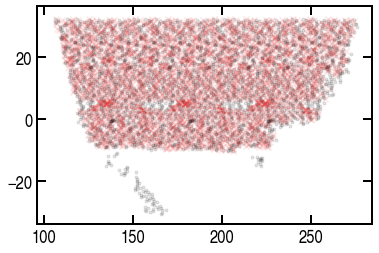

In [11]:
plt.scatter(*ut.hpix2radec(1024, dt['hpix'][::500]), alpha=0.1, marker='.')
plt.scatter(*ut.hpix2radec(1024, dt_good['hpix'][::500]), alpha=0.1, marker='x')

In [12]:
dt_good['label'].max()

53.0

In [13]:
dt['label'].max()

53.0

In [14]:
dt.size, dt_good.size

(1775126, 1661585)

## extremes of windows

In [4]:
windows = glob('/fs/ess/PHS0336/data/tanveer/dr9/v4/elg_linearp/windows_clean/linwindow_*.hp1024.fits')
print(len(windows))

1000


In [5]:
ranges = []
for wind in windows:
    map_ = hp.read_map(wind, verbose=False)
    is_seen = map_ != hp.UNSEEN
    ranges.append([map_[is_seen].min(), map_[is_seen].max()])
    print('.', end='')

/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [5]:
maps = np.zeros(12*1024**2)


for wind in windows:
    map_ = hp.read_map(wind, verbose=False)
    is_seen = map_ != hp.UNSEEN
    maps[is_seen] += map_[is_seen]
    #ranges.append([map_[is_seen].min(), map_[is_seen].max()])
    print('.', end='')

/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Text(0.5, 0, 'Nbar*W')

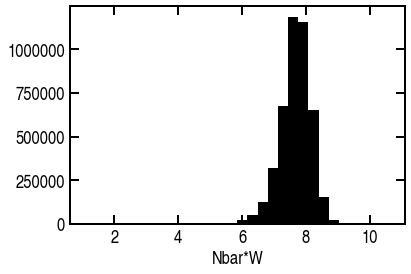

In [11]:
_ = plt.hist(maps[is_seen]/1000, bins=30)
plt.xlabel('Nbar*W')

In [16]:
np.var(maps[is_seen]/1000)

0.22316885758433658

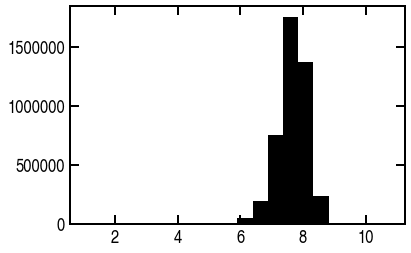

In [18]:
_ = plt.hist(map_[is_seen], bins=20)

In [20]:
np.var(map_[is_seen]), np.std(map_[is_seen])

(0.2232352561644738, 0.4724777837787442)

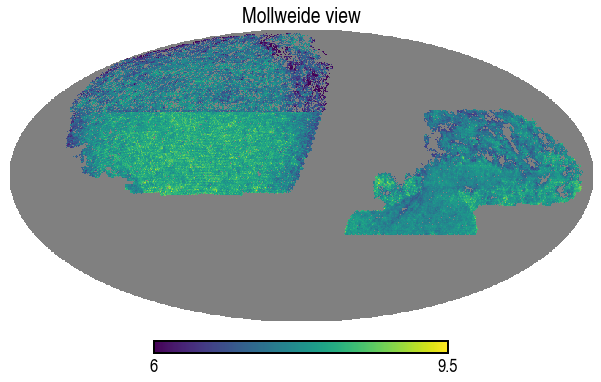

In [15]:
hp.mollview(map_, rot=120, min=6, max=9.5)

## Spectra of Windows

In [7]:
def read_clx(filename, ix=0):
    cl_sg = np.load(filename, allow_pickle=True).item()['cl_sg'][ix]['cl']
    return cl_sg

In [8]:
cl_now = read_clx('/fs/ess/PHS0336/data/tanveer/dr9/v3/clustering/cl_elg_bmzls_clean_1024_noweight.npy', 0)


cl_linw_0 = []
for i in range(1000):
    cl_ = read_clx(f'/fs/ess/PHS0336/data/tanveer/dr9/v3/clustering/cl_elg_bmzls_clean_1024_{i}_linp.npy', 0)
    cl_linw_0.append(cl_)

In [9]:
cl_linw_0 = np.array(cl_linw_0)

In [10]:
cl_linw_0.shape

(1000, 3072)

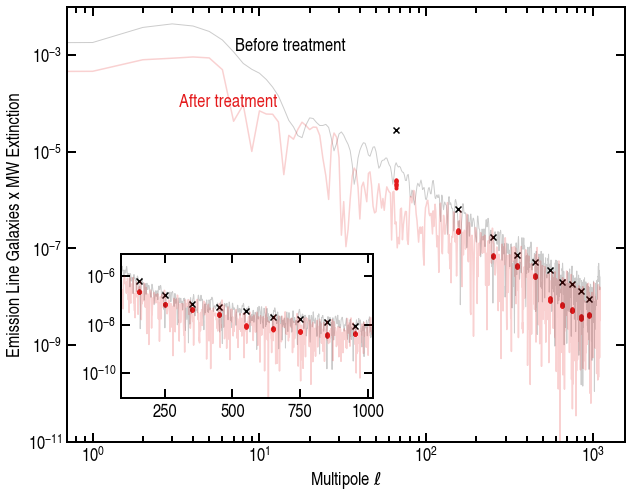

In [37]:
fg, ax0 = plt.subplots(figsize=(10, 8))
#fg.subplots_adjust(wspace=0.1)
ax1 = fg.add_axes([0.2, 0.2, 0.35, 0.25])

ax = [ax0, ax1]
el = np.arange(3072)
lbins = np.arange(0, 1100, 100)

def add_plot(ax):
    
    el_b, cl_b = ut.histogram_cell(el, cl_now, bins=lbins)
    ax.scatter(el_b, abs(cl_b), marker='x', color='C0')
    
    ax.plot(abs(cl_now)[:1100], lw=1, color='C0', alpha=0.2)
    ax.plot(abs(cl_linw_0.mean(axis=0))[:1100], 'C1-', alpha=0.2)
    
    for cl_j in cl_linw_0[::100]:
        #ax.plot(abs(cl_j), 'C1-', alpha=0.2, lw=1)  
        el_b, cl_b = ut.histogram_cell(el, cl_j, bins=lbins)
        ax.scatter(el_b, abs(cl_b), marker='.', color='C1')

        
    

add_plot(ax[0])
add_plot(ax[1])

ax[0].set(xscale='log', ylabel=r'Emission Line Galaxies x MW Extinction', 
          xlabel=r'Multipole $\ell$', ylim=(1.0e-11, 1.0e-2), yscale='log')
ax[1].set(xlim=(90, 1020), yscale='log', ylim=(9.0e-12, 8.e-6))

for axi in ax:
    axi.axhline(0, ls=':', lw=1)
    
ax[0].text(0.3, 0.9, 'Before treatment', transform=ax[0].transAxes)
ax[0].text(0.2, 0.77, 'After treatment', color='C1', transform=ax[0].transAxes)
    
#ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

#add_locators(ax[1], xmajor=100, ymajor=2.0e-8)
fg.savefig('cl_sg_dr9elgsxebv.png', dpi=300, bbox_inches='tight')

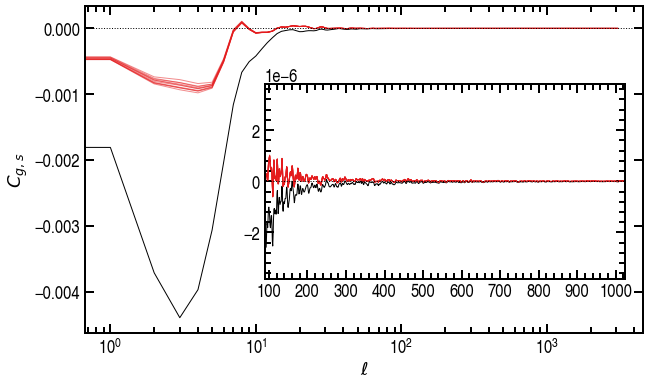

In [98]:
fg, ax0 = plt.subplots(figsize=(10, 6))
#fg.subplots_adjust(wspace=0.1)
ax1 = fg.add_axes([0.375, 0.25, 0.5, 0.45])

ax = [ax0, ax1]

def add_plot(ax):
    
    ax.plot(cl_now, lw=1)
    #ax.plot(cl_linw_0.mean(axis=0), 'C1-', alpha=0.5)
    
    for cl_j in cl_linw_0[::100]:
        ax.plot(cl_j, 'C1-', alpha=0.5, lw=1)        
    

add_plot(ax[0])
add_plot(ax[1])

ax[0].set(xscale='log', ylabel=r'$C_{g,s}$', xlabel=r'$\ell$')
#ax[0].set_yscale('symlog', linthreshy=1.0e-3)

ax[1].set(xlim=(90, 1024), ylim=(-3.8e-6, 3.8e-6))

for axi in ax:
    axi.axhline(0, ls=':', lw=1)
    
ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

add_locators(ax[1], xmajor=100, ymajor=2.0e-6)

In [ ]:
### windows = glob('/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linearp/windows_clean/linwindow_*.hp1024.fits')
print(len(windows))

ds = []
for i, wind in enumerate(windows[:10]):
    
    d_ = hp.read_map(wind, verbose=False, dtype=np.float32)

    mask = d_!=hp.UNSEEN
    for val in np.percentile(d_[mask], [0, 1, 50, 99, 100]):print('%.1f'%val, end=' ')
    
    d_ = d_ / np.mean(d_[mask])
    dh = hp.ma(d_)    
    dh.mask = np.logical_not(mask)    
    m_ = hp.anafast(dh.filled(), lmax=1024)
    ds.append(m_)
    
    print()
    
ds = np.array(ds)

In [5]:
ds.shape

(10, 1025)

In [6]:
from lssutils.utils import histogram_cell

In [7]:
dsh = []
for ds_i in ds:
    el_b, cl_b = histogram_cell(np.arange(ds_i.size), ds_i, 
                                bins=np.linspace(0.0, 1026, 20))
    dsh.append(cl_b)
    
dsh = np.array(dsh)
print(dsh.shape)

(10, 19)


[Text(0.5, 0, '$\\ell$')]

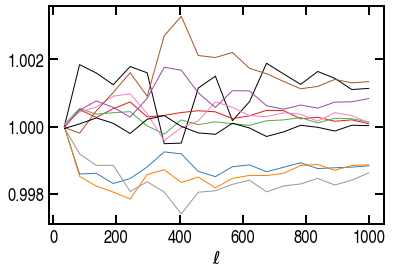

In [8]:
fg, ax = plt.subplots()

for dsi in dsh:
    ax.plot(el_b, dsi / dsh.mean(axis=0), lw=1, ls='-')
ax.set(xlabel=r'$\ell$')

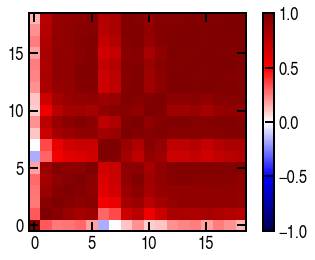

In [9]:
fg, ax = plt.subplots()

map_ = ax.imshow(np.corrcoef(dsh, rowvar=False), 
                 origin='lower', cmap='seismic', vmin=-1, vmax=1)

fg.colorbar(map_)

In [8]:
for region in ['bmzls', 'ndecals', 'sdecals']:
    d = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v4/nelg_features_{region}_clean_1024.fits')
    print(region, np.percentile(d['label'], [0, 1, 50, 99, 100]))

bmzls [ 0.  0.  6. 14. 77.]
ndecals [ 0.  1.  7. 16. 53.]
sdecals [ 0.  1.  7. 15. 42.]


In [9]:
region = 'ndecals'
d = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nelg_features_{region}_1024.fits')
d1 = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v4/nelg_features_{region}_clean_1024.fits')

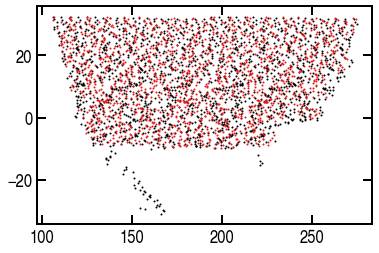

In [10]:
for di in [d, d1]:
    plt.scatter(*ut.hpix2radec(1024, di['hpix'][::1000]), 1.)

In [16]:
d['label'][7:10], d1['label'][:3]

(array([2., 4., 6.]), array([1., 4., 6.]))

## Feature Selection for DESI ELG DR9

In [4]:
cc = {}
for r in ['bmzls', 'ndecals', 'sdecals']:
    dt = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nelg_features_{r}_1024.fits')
    cc[r] = pcc(dt['features'], dt['label'], return_err=True)

In [5]:
from matplotlib.backends.backend_pdf import 

'NimbusSansNarrow-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusSansNarrow-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusSansNarrow-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusSansNarrow-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


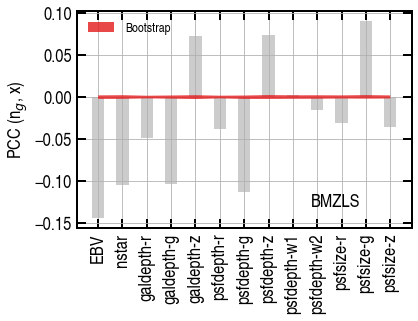

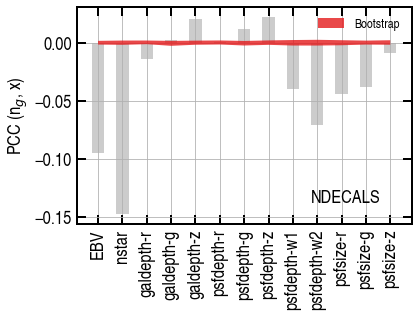

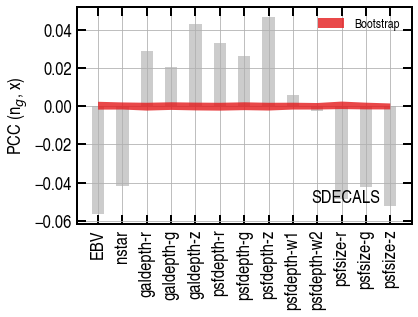

In [14]:
pdf = PdfPages('pcc_dr9elg.pdf')

xlabels = ['EBV', 'nstar']\
        + ['galdepth-%s'%s for s in ['r', 'g', 'z']]\
        + ['psfdepth-%s'%s for s in ['r', 'g', 'z', 'w1', 'w2']]\
        + ['psfsize-%s'%s for s in ['r', 'g', 'z']]
xticks = [i for i in range(len(xlabels))]


for ri, cci in cc.items():
    
    fg, ax = plt.subplots()
    
    ax.bar(xticks, cci[0], width=0.5, alpha=0.2)
    ax.fill_between(xticks, *np.percentile(cci[1], [0, 100], axis=0), alpha=0.8, zorder=10,
                    label='Bootstrap')

    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, rotation=90)
    ax.text(0.7, 0.1, ri.upper(), transform=ax.transAxes)
    ax.grid(True)
    ax.legend()
    ax.set_ylabel('PCC (n$_{g}$, x)')
    
    pdf.savefig(bbox_inches='tight')

pdf.close()

In [8]:
corrm = {}
for r in ['bmzls', 'ndecals', 'sdecals']:
    dt = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nelg_features_{r}_1024.fits')
    corrm[r] = np.corrcoef(dt['features'], rowvar=False)

'NimbusSansNarrow-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusSansNarrow-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusSansNarrow-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusSansNarrow-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


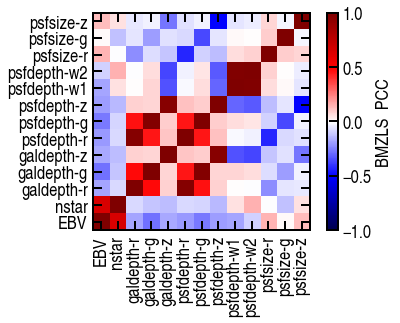

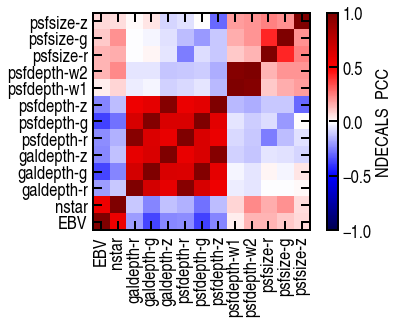

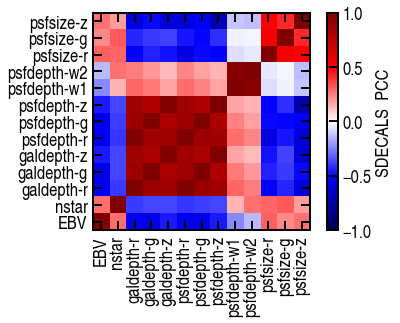

In [13]:
pdf = PdfPages('pcc_imaging.pdf')

xlabels = ['EBV', 'nstar']\
        + ['galdepth-%s'%s for s in ['r', 'g', 'z']]\
        + ['psfdepth-%s'%s for s in ['r', 'g', 'z', 'w1', 'w2']]\
        + ['psfsize-%s'%s for s in ['r', 'g', 'z']]
xticks = [i for i in range(len(xlabels))]


for ri, corr_i in corrm.items():
    
    fg, ax = plt.subplots()
    
    map_i = plt.imshow(corr_i, origin='lower', vmin=-1, vmax=1.0, cmap='seismic')
    
    
    ax.set_yticks(xticks)
    ax.set_yticklabels(xlabels)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, rotation=90)
    fg.colorbar(map_i, label=f'{ri.upper()}  PCC')
    
    pdf.savefig(bbox_inches='tight')

pdf.close()

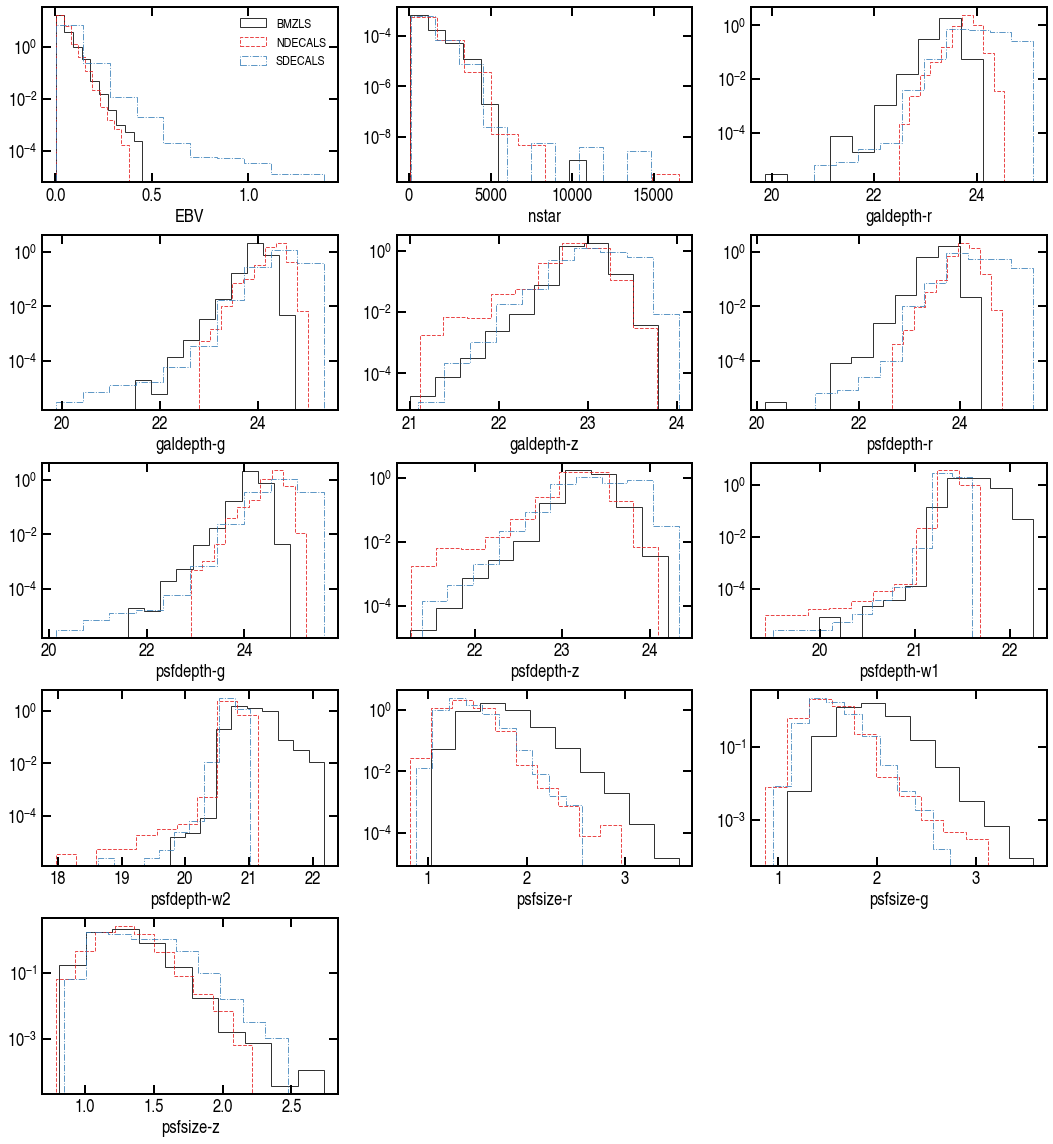

In [35]:
fg, ax = plt.subplots(ncols=3, nrows=5, figsize=(18, 20))
ax = ax.flatten()
fg.subplots_adjust(hspace=0.3)
fg.delaxes(ax[-1])
fg.delaxes(ax[-2])

for r in ['bmzls', 'ndecals', 'sdecals']:
    dt = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nelg_features_{r}_1024.fits')
    for i, x in enumerate(dt['features'].T):
        ax[i].hist(x, alpha=0.8, histtype='step', label=r.upper(), density=True)
    
# ax[0].set_ylim(1, 1.0e7)    
for i, a in enumerate(ax[:-2]):
    a.set_yscale('log')
    a.set_xlabel(xlabels[i])
ax[0].legend()

In [ ]:
corrm = {}
for r in ['bmzls', 'ndecals', 'sdecals']:
    dt = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nelg_features_{r}_1024.fits')
    corrm[r] = np.corrcoef(dt['features'], rowvar=False)

In [5]:
chains = np.load('/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linearp/mcmc_sdecals_1024.npz')['chain']

In [6]:
chains.shape

(1000, 400, 12)

In [7]:
from lssutils.extrn.mcmc import gelman_rubin

In [15]:
rvalues = gelman_rubin(chains[500:, :, :])

In [21]:
np.all(abs(1-rvalues) < 0.01)

True

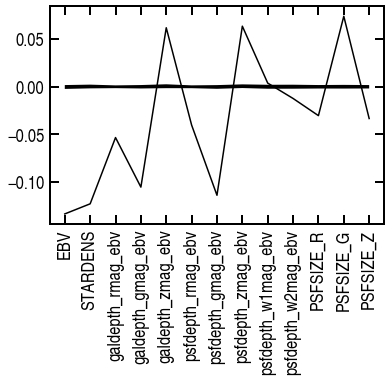

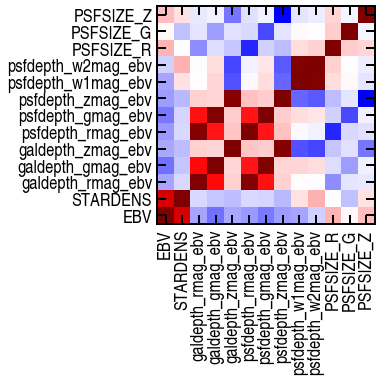

In [31]:
model = src.LinearRegression(add_bias=True)

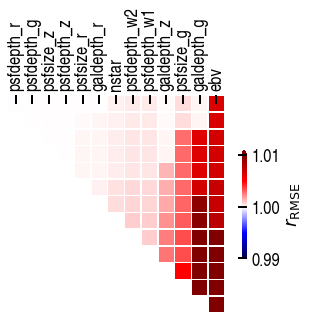

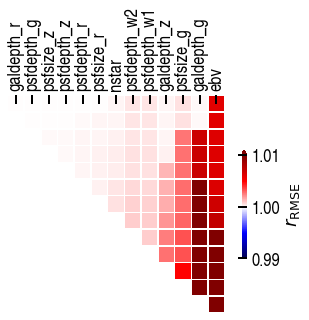

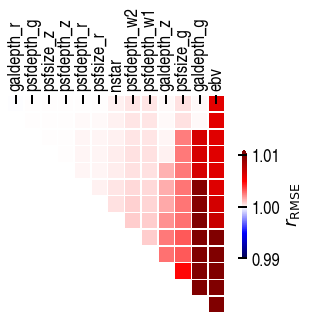

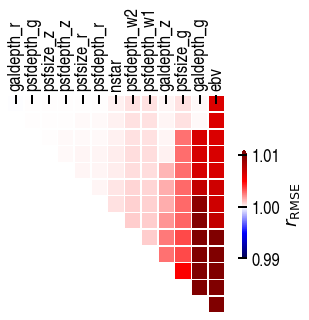

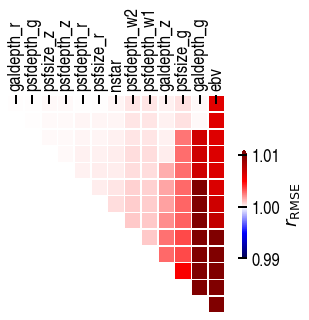

In [32]:
dl = src.MyDataLoader('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nelg_features_bmzls_1024.fits', 
                      do_kfold=True, seed=4200)

for i in range(5):
    
    fs = src.FeatureElimination(model, dl.load_data(-1, i))
    fs.run([j for j in range(13)])

    maps_dr9 = ['ebv', 'nstar']\
                + [f'galdepth_{b}' for b in ['r', 'g', 'z']]\
                + [f'psfdepth_{b}' for b in ['r', 'g', 'z', 'w1', 'w2']] \
                + [f'psfsize_{b}' for b in ['r', 'g', 'z']]

    fs.plot(labels=maps_dr9, cmap='seismic', vmin=0.99, vmax=1.01)

In [14]:
np.percentile(cc[1], [0, 100], axis=0)

array([[-0.00219182, -0.00213417, -0.00159139, -0.00189115, -0.00234959,
        -0.00158176, -0.00221845, -0.00221919, -0.00206963, -0.00199718,
        -0.00171004, -0.00189476, -0.00171146],
       [ 0.00199508,  0.00222681,  0.00157321,  0.00187049,  0.00222902,
         0.00162367,  0.00181897,  0.00236214,  0.00207354,  0.00213213,
         0.00197478,  0.00233367,  0.00196767]])

In [3]:
PNLL, kw_loss = init_loss('pnll')
DNNP = init_model('dnnp')
DNNP, PNLL

(sysnet.sources.models.DNNPoisson, torch.nn.modules.loss.PoissonNLLLoss)

In [4]:
chcks = glob('/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnnp/bmzls_1024/model_*/snapshot_*')
print(len(chcks))

# import torch
# min_val = 1.0e6
# val_loss = []
# best_ch = None
# best_name = None

# for ch in chcks:
#     dch = torch.load(ch)
    
#     bvl = dch['best_val_loss']
#     if bvl < min_val:
#         min_val = bvl
#         best_ch = dch
#         best_name = ch

1000


In [5]:
model = DNNP(4, 20, input_dim=11)
best_ch = load_checkpoint('/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnnp/bmzls_1024/model_2_2285845164/snapshot_169.pth.tar', model)

In [6]:
axes = [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12]
axes

[0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12]

In [8]:
def load_data(fitsfile, stats, axes):
    templates = ft.read(fitsfile)
    img_data = ImagingData(templates, stats, axes=axes)        
    return MyDataSet(img_data.x, img_data.y, img_data.p, img_data.w)

In [9]:
dl = load_data('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nelg_features_bmzls_1024.fits', 
               best_ch['stats'], axes)

In [15]:
from torch.autograd.functional import hessian

In [52]:
pnll = PNLL(**kw_loss)
model.eval()

inputs = dl.x[:2]
observed = dl.y[:2]
fpix = dl.w[:2]

def my_pnll(inputs):
    y = model(inputs)
    loss_ = pnll(y*fpix, observed)
    loss_ = loss_*fpix
    return loss_.sum()

In [37]:
import torch

In [53]:
hess = hessian(my_pnll, inputs)

In [66]:
def pow_adder_reducer(x1, x2): # https://pytorch.org/docs/stable/generated/torch.autograd.functional.hessian.html
    return (2 * x1.pow(2) + 3 * x2.pow(2) + x2.pow(3)).sum()

inputs = (torch.Tensor([1., 1., 1.]), torch.Tensor([1., 2., 3.]))
hessian(pow_adder_reducer, inputs)

((tensor([[4., 0., 0.],
          [0., 4., 0.],
          [0., 0., 4.]]),
  tensor([[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]])),
 (tensor([[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]),
  tensor([[12.,  0.,  0.],
          [ 0., 18.,  0.],
          [ 0.,  0., 24.]])))

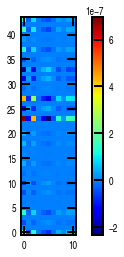

In [55]:
plt.imshow(hess.flatten().reshape(-1, 11), origin='lower', cmap='jet')
plt.colorbar()

In [31]:
hess

tensor([[[[ 6.8849e-04, -2.4714e-03, -1.1571e-03,  ..., -2.4358e-03,
            7.7143e-03, -4.5233e-03],
          [ 6.8635e-04, -1.2519e-03,  1.4255e-03,  ...,  6.3791e-04,
           -4.6962e-04,  1.4836e-03],
          [ 6.8128e-04, -1.3009e-03,  1.4490e-03,  ...,  6.2471e-04,
           -4.4322e-04,  1.5141e-03],
          ...,
          [ 4.9923e-04,  9.0760e-04,  4.0069e-04,  ..., -1.6027e-03,
           -9.4980e-04, -8.4215e-04],
          [ 6.8515e-04, -7.8491e-04,  1.0604e-03,  ...,  2.3639e-04,
           -2.2571e-04,  7.3965e-04],
          [ 7.8901e-04,  2.5246e-04,  4.6629e-04,  ...,  3.5440e-04,
           -6.2980e-04,  4.5393e-04]],

         [[-2.4714e-03,  6.2579e-03, -6.1544e-03,  ...,  2.8408e-04,
           -6.4122e-04, -5.4241e-03],
          [-1.2184e-03,  3.0874e-03, -2.9308e-03,  ..., -1.5850e-03,
            5.8466e-04, -3.2558e-03],
          [-1.2123e-03,  3.2085e-03, -3.0030e-03,  ..., -1.5466e-03,
            5.4310e-04, -3.3441e-03],
          ...,
     

## Extreme Window

1000

In [5]:
windows = glob('/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnnp/windows/nnwindow_*')
len(windows)


ds = []
for wind in windows[:10]:
    d_ = hp.read_map(wind, verbose=False, dtype=np.float32)

    mask = d_!=hp.UNSEEN
    d_ = d_ / np.mean(d_[mask])
    d_c = d_.clip(0.1, 10)
    
    dh = hp.ma(d_)
    dhc = hp.ma(d_c)
    
    dh.mask = np.logical_not(mask)
    dhc.mask = np.logical_not(mask)
    
    m_ = hp.anafast(dh.filled(), lmax=1024)
    mc_ = hp.anafast(dhc.filled(), lmax=1024)    
    ds.append([m_, mc_])
#     plt.loglog(m_)
    print('.', end='')
    
    
ds = np.array(ds)
fg, ax = plt.subplots(ncols=2, figsize=(12, 4))

dsm = np.mean(ds, axis=0)

for i in range(10):
    dsi = ds[i]
    for j, dsj in enumerate(dsi):
        ax[j].plot(dsj/dsm[j, :])
        if np.any(dsj/dsm[j, :] > 2):print(i)

for a in ax:a.set(xlabel=r'$\ell$')

..........

5


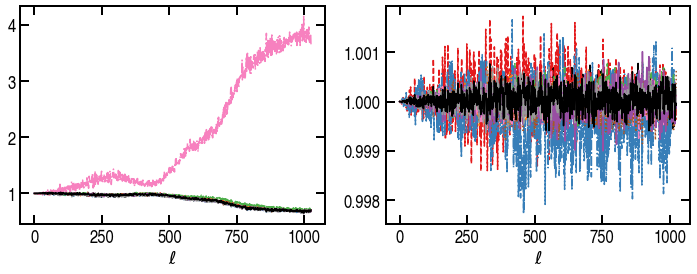

In [11]:
windows[5], windows[0]

('/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnnp/windows/nnwindow_563.hp1024.fits',
 '/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnnp/windows/nnwindow_411.hp1024.fits')

In [12]:
wind_bad = hp.read_map('/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnnp/windows/nnwindow_563.hp1024.fits')
wind_ok = hp.read_map('/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnnp/windows/nnwindow_411.hp1024.fits')

/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


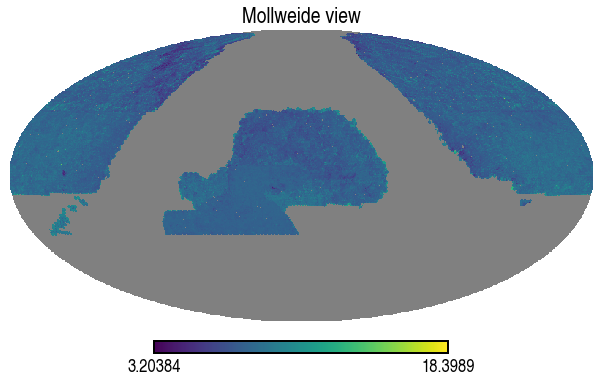

In [13]:
hp.mollview(wind_bad)

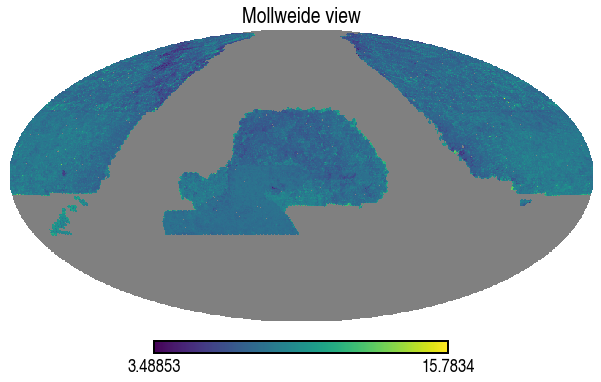

In [14]:
hp.mollview(wind_ok)

In [47]:
is_high = wind_bad > 30

wind_mask = wind_bad.copy()
wind_mask[is_high] = hp.UNSEEN

In [48]:
cl_masked = hp.anafast(wind_mask)

In [15]:
cl_bad = hp.anafast(wind_bad)

In [16]:
cl_ok = hp.anafast(wind_ok)

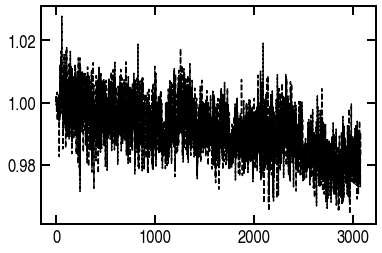

In [50]:
plt.plot(cl_ok/cl_masked, '--')

[]

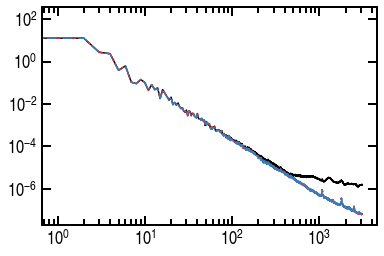

In [49]:
plt.plot(cl_bad, '-',
         cl_ok, '--', 
         cl_masked, '-.')

plt.loglog()

(array([7.900000e+01, 1.869300e+04, 1.754589e+06, 3.208046e+06,
        9.007000e+04, 7.343000e+03, 4.590000e+02, 7.200000e+01,
        1.800000e+01, 4.600000e+01]),
 array([ 1.90822601,  3.84519749,  5.78216896,  7.71914043,  9.65611191,
        11.59308338, 13.53005486, 15.46702633, 17.4039978 , 19.34096928,
        21.27794075]),
 <a list of 10 Patch objects>)

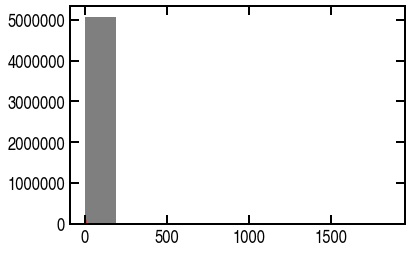

In [19]:
is_seen = (wind_ok != hp.UNSEEN)
plt.hist(wind_bad[is_seen], alpha=0.5)
plt.hist(wind_ok[is_seen], alpha=0.5)

In [20]:
wind_bad[is_seen].max()

1858.33740234375

In [22]:
wind_ok[is_seen].max()

21.27794075012207

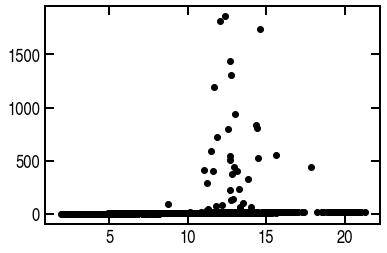

In [23]:
plt.scatter(wind_ok[is_seen], wind_bad[is_seen])

In [33]:
is_seen = (wind_bad!= hp.UNSEEN)
is_bad = (wind_bad > 30) & is_seen

In [34]:
is_bad.sum()

37

In [44]:
is_bad.sum()/is_seen.sum()

7.2843034089555586e-06

In [35]:
radec_bad = ut.hpix2radec(1024, np.argwhere(is_bad).flatten())
radec = ut.hpix2radec(1024, np.argwhere(is_seen).flatten())

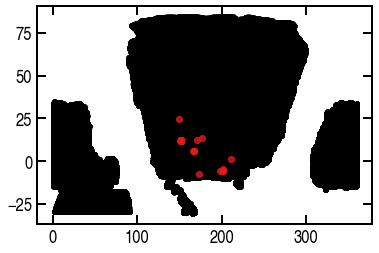

In [36]:
plt.scatter(*radec, marker='.', alpha=0.5)
plt.scatter(*radec_bad, alpha=0.8)

In [37]:
dt = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nelg_features_ndecals_1024.fits')

In [38]:
nstar = ut.make_hp(1024, dt['hpix'], dt['features'][:, 1], fill_nan=True)

In [39]:
nstar[is_bad]

array([419.40029907, 343.14569092, 228.76379395, 476.59124756,
       400.3366394 , 400.3366394 , 400.3366394 , 400.3366394 ,
       400.3366394 , 400.3366394 , 400.3366394 , 400.3366394 ,
       533.78216553, 457.52758789, 571.90948486, 457.52758789,
       457.52758789, 457.52758789, 438.46392822, 438.46392822,
       457.52758789, 438.46392822, 438.46392822, 438.46392822,
       438.46392822, 343.14569092, 343.14569092, 495.65487671,
       381.27297974, 495.65487671, 457.52758789, 629.10046387,
       324.08203125, 571.90948486, 400.3366394 , 400.3366394 ,
       457.52758789])

In [41]:
np.percentile(nstar[~np.isnan(nstar)], [0, 50, 100])

array([   76.25460052,   629.10046387, 16547.24804688])

## MCMC linear 

In [69]:
class Chains:
    
    def __init__(self, filename, plot=False):
    
        chains_ = np.load(filename, allow_pickle=True)
        self.chains = chains_['chain']
        self.stats = {'x':chains_['x']}#, 'y':chains_['y']}
        print(self.chains.shape)
        self.ndim = self.chains.shape[-1]

        if plot:
            fg, ax = plt.subplots(nrows=self.ndim, figsize=(8, self.ndim*1), sharex=True)#, sharey=True)
            ax = ax.flatten()
            #ax[0].set_ylim(-.5, .5)

            for i, ix in enumerate(range(self.ndim)): #[0, 1, 2, 3, 5]):
                for j in range(400):
                    ax[i].plot(self.chains[:, j, ix])

                ax[i].axhline(0.0, ls=':')    
            fg.show()
        
    def get_sample(self, skip_rows=400):
        return self.chains[skip_rows:, :, :].reshape(-1, self.ndim)

(2000, 400, 12)
(2000, 400, 12)
(2000, 400, 12)


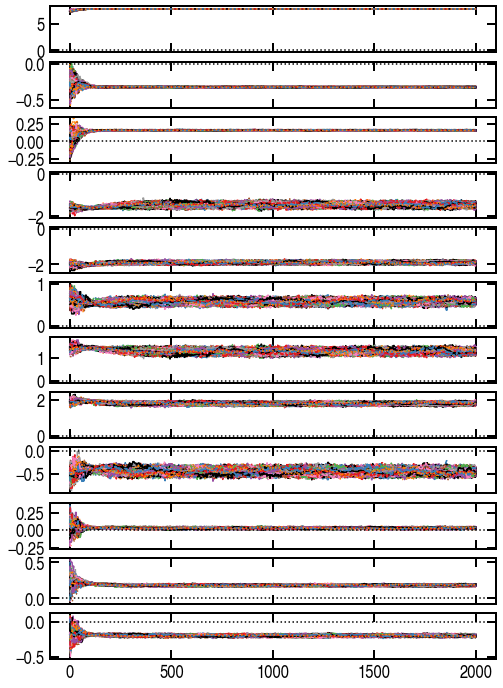

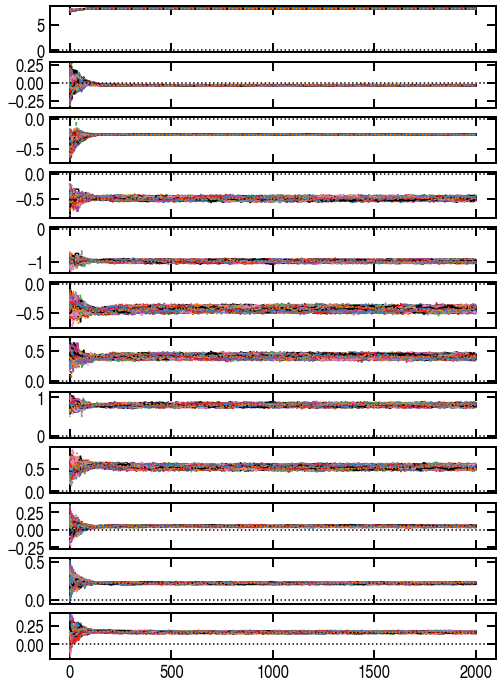

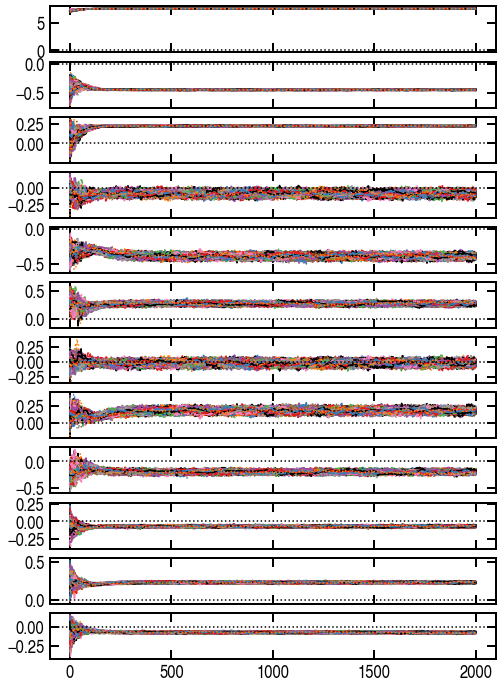

In [70]:
ch1 = Chains('/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linearp/mcmc_sdecals_clean_1024.npz', True)
ch2 = Chains('/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linearp/mcmc_ndecals_clean_1024.npz', True)
ch3 = Chains('/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linearp/mcmc_bmzls_clean_1024.npz', True)

In [71]:
s1 = ch1.get_sample(skip_rows=1000)
s2 = ch2.get_sample(skip_rows=1000)
s3 = ch3.get_sample(skip_rows=1000)

In [72]:
columns = np.array(['c', 'EBV', 'star']\
          + [f'galdepth-{b}' for b in ['r', 'g', 'z']]\
          + [f'psfdepth-{b}' for b in ['r', 'g', 'z']]\
          + [f'psfsize-{b}' for b in ['r', 'g', 'z']]) # 
len(columns)

12

In [73]:
ix = [0, 1, 4, 9]

In [74]:
fg = corner.corner(s1, labels=columns, color='C2', group='sdecals')
corner.corner(s2, labels=columns, color='C1', fig=fg, group='ndecals')
corner.corner(s3, labels=columns, color='C0', fig=fg, group='bmzls', labelpad=0.2)
# fg.legend()
fg.align_labels()
plt.show()

AttributeError: 'function' object has no attribute 'corner'

In [75]:
import corner

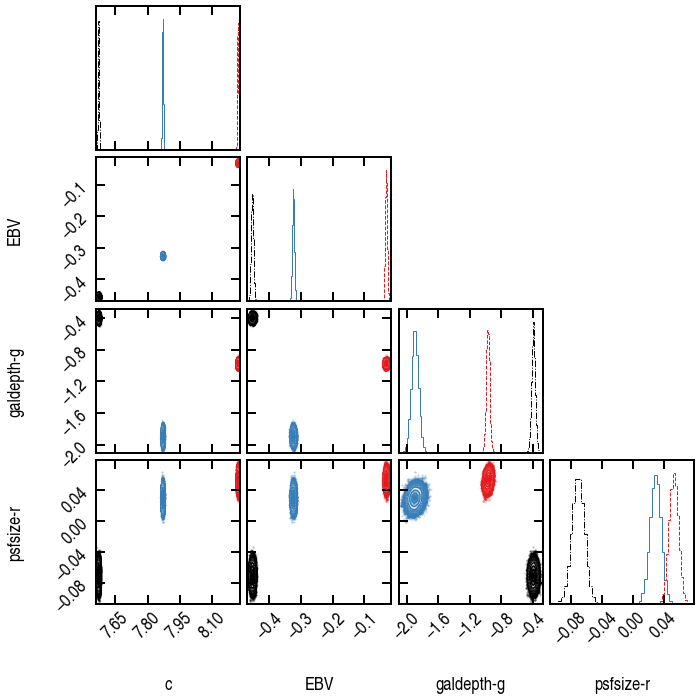

In [77]:
# l1 = mlines.Line2D([], [], color='C2', label='SDECALS', ls='-')
# l2 = mlines.Line2D([], [], color='C1', label='NDECALS', ls='--')
# l3 = mlines.Line2D([], [], color='C0', label='BMZLS', ls='-.')


ix = [0, 1, 4, 9]
fg = corner.corner(s1[:, ix], labels=columns[ix], color='C2', group='sdecals')
corner.corner(s2[:, ix], labels=columns[ix], color='C1', fig=fg, group='ndecals')
corner.corner(s3[:, ix], labels=columns[ix], color='C0', fig=fg, group='bmzls', labelpad=0.2)

# fg.legend(handles=[l1, l2, l3], bbox_to_anchor=(0., 0.8, 0.8, .0), loc=4)
fg.align_labels()
# fg.savefig('mcmc.pdf', bbox_inches='tight')

## Fpix

In [11]:
regions = ['bmzls', 'ndecals', 'sdecals']
fpix = {}
for region in regions:
    df_ = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v4/nelg_features_{region}_clean_1024.fits')
    fpix[region] = ut.make_hp(1024, df_['hpix'], df_['fracgood'])

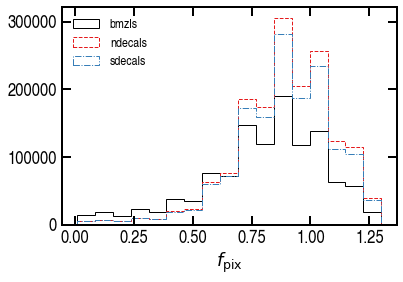

In [16]:
for region in regions:
    plt.hist(fpix[region], label=region, bins=17, histtype='step', range=(0.01, 1.3))
plt.xlabel(r'$f_{\rm pix}$')
plt.legend(loc=2)
# plt.yscale('log')
# plt.ylim()

In [17]:
fpix_map = np.zeros(12*1024*1024)

for region in regions:
    fpix_map += fpix[region]

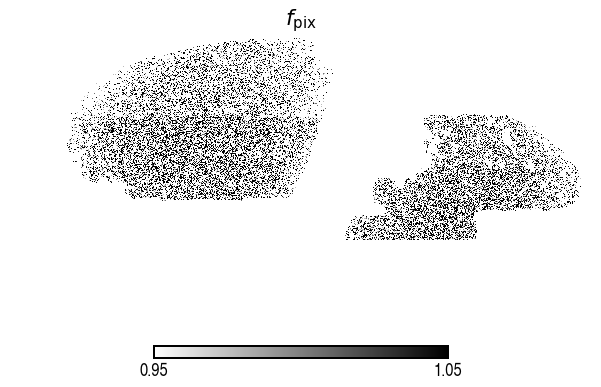

In [18]:
hp.mollview(fpix_map, rot=120, min=0.95, max=1.05, cmap=plt.cm.binary, title=r'$f_{\rm pix}$')

In [19]:
hp.write_map('fpix_map_clean.hp1024.fits', fpix_map, fits_IDL=False, dtype=np.float64)

In [21]:
!gzip fpix_map_clean.hp1024.fits

In [22]:
ls

cl_dr9elg.pdf                           logHIvsHI.ipynb
cl_sg_dr9elgsxebv.png                   mcmc.pdf
clustering_elg1024dr9.ipynb             meanden_ebv_windows.pdf
clustering_sepvsfull.ipynb              nn_windows.pdf
cl_windows.pdf                          pcc_dr9elg.pdf
cross_correlation_nonlinear-1024.ipynb  pcc_imaging.pdf
cross_correlation_nonlinear.ipynb       power_templates.ipynb
Ensemble.ipynb                          selection_functions.ipynb
EnsembleWindows.ipynb                   siena_galaxy.ipynb
fpix_map_clean.hp1024.fits.gz           split_test.ipynb
GaussianMocks.ipynb                     TestCoordinatesNside.ipynb
LinEnsemble.ipynb                       Window_Vs_Mask.ipynb
LinEnsemble-weighted.ipynb


## Windows

In [62]:
ws0 = glob('/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnnp/windows/nn*.fits')
ws0 = np.random.permutation(ws0)
len(ws0), ws0[:5]

(1000,
 array(['/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnnp/windows/nnwindow_294.hp1024.fits',
        '/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnnp/windows/nnwindow_627.hp1024.fits',
        '/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnnp/windows/nnwindow_899.hp1024.fits',
        '/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnnp/windows/nnwindow_749.hp1024.fits',
        '/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnnp/windows/nnwindow_713.hp1024.fits'],
       dtype='<U77'))

In [63]:
ws1 = glob('/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linearp/windows/lin*.fits')
ws1 = np.random.permutation(ws1)
len(ws1), ws1[:5]

(1000,
 array(['/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linearp/windows/linwindow_476.hp1024.fits',
        '/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linearp/windows/linwindow_479.hp1024.fits',
        '/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linearp/windows/linwindow_901.hp1024.fits',
        '/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linearp/windows/linwindow_332.hp1024.fits',
        '/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linearp/windows/linwindow_483.hp1024.fits'],
       dtype='<U81'))

In [66]:
d0 = []
d1 = []
kw = dict(verbose=False, dtype=np.float32)

for i in range(10):

    d0.append(hp.read_map(ws0[i], **kw))
    d1.append(hp.read_map(ws1[i], **kw))
    
    print('.', end='')

..........

## Mollweide window

<ipython-input-68-4a7c8385747a>:25: RuntimeWarning: invalid value encountered in subtract
  image2 = mollview(d_i-d_i1, -1, 1, '', figax=[fig, ax_i3], cmap=plt.cm.bwr)
'NimbusSansNarrow-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusSansNarrow-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


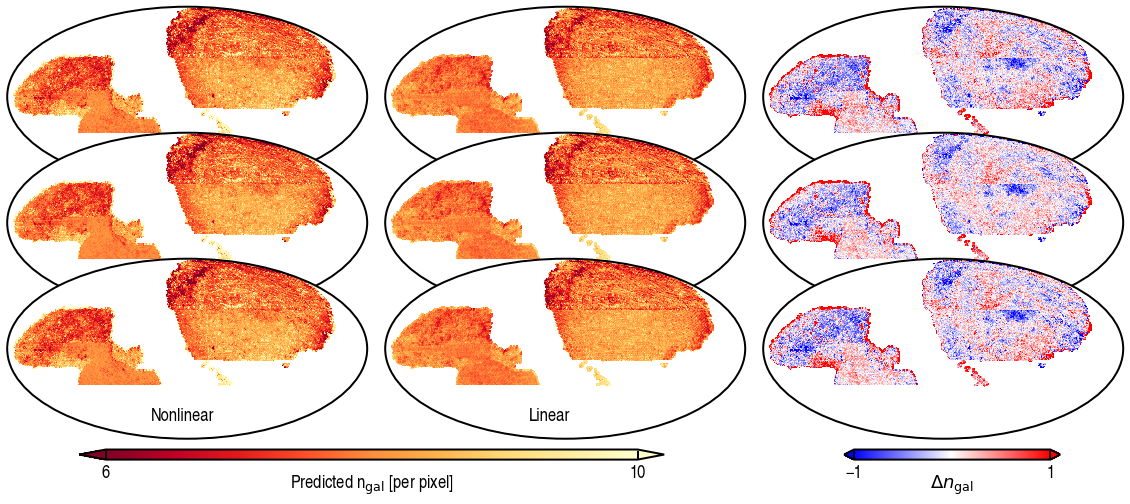

In [68]:
fig = plt.figure(figsize=(5, 7))
ax0  = fig.add_axes([0, 0, 1., 1],       projection='mollweide')
ax1  = fig.add_axes([0., -0.25, 1., 1], projection='mollweide')
ax2  = fig.add_axes([0., -0.50, 1., 1], projection='mollweide')

ax3  = fig.add_axes([1.05, 0, 1., 1],       projection='mollweide')
ax4  = fig.add_axes([1.05, -0.25, 1., 1], projection='mollweide')
ax5  = fig.add_axes([1.05, -0.50, 1., 1], projection='mollweide')

ax6  = fig.add_axes([2.1, 0, 1., 1],       projection='mollweide')
ax7  = fig.add_axes([2.1, -0.25, 1., 1], projection='mollweide')
ax8  = fig.add_axes([2.1, -0.50, 1., 1], projection='mollweide')

for i, (ax_i1, ax_i2, ax_i3) in enumerate(zip([ax0, ax1, ax2], 
                                              [ax3, ax4, ax5],
                                              [ax6, ax7, ax8])):
    d_i = d0[i]*1.0
    d_i[d_i==hp.UNSEEN] = np.inf
    image0 = mollview(d_i, 6, 10, '', figax=[fig, ax_i1], cmap=plt.cm.YlOrRd_r)

    d_i1 = d1[i]*1.0
    d_i1[d_i1==hp.UNSEEN] = np.inf
    image1 = mollview(d_i1, 6, 10, '', figax=[fig, ax_i2], cmap=plt.cm.YlOrRd_r)
    
    image2 = mollview(d_i-d_i1, -1, 1, '', figax=[fig, ax_i3], cmap=plt.cm.bwr)
    
    ax_i1.set(xticks=[], yticks=[])
    ax_i2.set(xticks=[], yticks=[])
    ax_i3.set(xticks=[], yticks=[])
    
    
    
cax = plt.axes([0.2, -0.22, 1.625, 0.02])  # horizontal
cb  = fig.colorbar(image0, cax=cax, label=r'Predicted n$_{{\rm gal}}$ [per pixel]', fraction=0.15,
                   shrink=0.6, ticks=[6, 10],
                   orientation='horizontal', extend='both')        
cb.ax.xaxis.labelpad = -8
cb.solids.set_edgecolor("face")


cax = plt.axes([2.325, -0.22, 0.6, 0.02])  # horizontal
cb  = fig.colorbar(image2, cax=cax, label=r'$\Delta n_{{\rm gal}}$', fraction=0.15,
                   shrink=0.6, ticks=[-1, 1],
                   orientation='horizontal', extend='both')        
cb.ax.xaxis.labelpad = -8
cb.solids.set_edgecolor("face")


ax2.text(0.4, 0.1, 'Nonlinear', transform=ax2.transAxes)
ax5.text(0.4, 0.1, 'Linear', transform=ax5.transAxes)

fig.savefig('nn_windows.pdf', bbox_inches='tight')

## Mean Density

In [69]:
regions = ['bmzls', 'ndecals', 'sdecals']
df = {}

for region in regions:
    df[region] = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nelg_features_{region}_1024.fits')

In [70]:
ng_data = {}

for region in regions:
    ng_ = ut.make_hp(1024, df[region]['hpix'], df[region]['label'])
    fr_ = ut.make_hp(1024, df[region]['hpix'], df[region]['fracgood'])
    ms_ = ut.make_hp(1024, df[region]['hpix'], 1.0) > 0.5
    st_ = ut.make_hp(1024, df[region]['hpix'], df[region]['features'][:, 0])[:, np.newaxis]
    
    ng_data[region] = get_meandensity(ng_, fr_, ms_, st_, njack=20)
    print(region)

bmzls
ndecals
sdecals


In [73]:
ng_wind0 = {}
ng_wind1 = {}

for region in regions:
    fr_ = ut.make_hp(1024, df[region]['hpix'], df[region]['fracgood'])
    ms_ = ut.make_hp(1024, df[region]['hpix'], 1.0) > 0.5
    st_ = ut.make_hp(1024, df[region]['hpix'], df[region]['features'][:, 0])#[:, np.newaxis]

    ng_wind = []
    for d_i in d0:
        d_ij = d_i*1.0
        d_ij = d_ij / np.median(d_ij[ms_])
        d_ij = d_ij.clip(0.5, 2.0)
        ng_wind.append(hist((d_ij*fr_)[ms_], fr_[ms_], st_[ms_], bins=ng_data[region][0]['bin_edges']))
        print('.', end='')
    ng_wind0[region] = ng_wind
    print('')
    
    ng_wind = []
    for d_i in d1:
        d_ij = d_i*1.0
        d_ij = d_ij / np.median(d_ij[ms_])
        d_ij = d_ij.clip(0.5, 2.0)
        ng_wind.append(hist((d_ij*fr_)[ms_], fr_[ms_], st_[ms_], bins=ng_data[region][0]['bin_edges']))
        print('.', end='')
        
    ng_wind1[region] = ng_wind       
    print(region)

..........
..........bmzls
..........
..........ndecals
..........
..........sdecals


'NimbusSansNarrow-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusSansNarrow-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


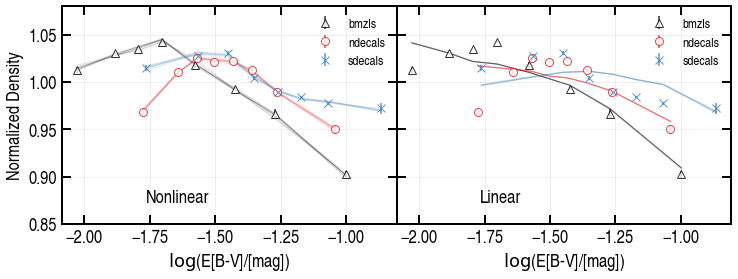

In [76]:
def add_plot(ax, ng_data, nb_winds, text=''):
    
    mk = ['^', 'o', 'x']

    i = 0
    for n_i, ng_i in ng_data.items():
        ln = ax.errorbar(np.log10(ng_i[0]['bin_avg']), ng_i[0]['nnbar'], yerr=ng_i[0]['nnbar_err'], 
                         marker=mk[i], markersize=8, mfc='w', alpha=0.8, ls='None', label=n_i)
        i += 1
        for ng_j in nb_winds[n_i]:
            ax.plot(np.log10(ng_j[0]), ng_j[1], color=ln[0].get_color(), 
                    ls='-', lw=1, alpha=0.1, zorder=-10)

    ax.set(xlabel=r'$\log$(E[B-V]/[mag])') # ylim=(0.89, 1.05), 
    ax.legend()
    ax.grid(lw=1, alpha=0.2)
    ax.text(0.25, 0.1, text, transform=ax.transAxes)
    

    
fg, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True, sharex=True)
fg.subplots_adjust(wspace=0.0)


add_plot(ax[0], ng_data, ng_wind0, 'Nonlinear')
add_plot(ax[1], ng_data, ng_wind1, 'Linear')
ax[0].set_ylabel('Normalized Density')
ax[0].set_ylim(0.85, 1.08)

fg.savefig('meanden_ebv_windows.pdf', bbox_inches='tight')

## Angular Power

In [82]:
cl_data = {}

for region in regions:
    ng_ = ut.make_hp(1024, df[region]['hpix'], df[region]['label'])
    fr_ = ut.make_hp(1024, df[region]['hpix'], df[region]['fracgood'])
    ms_ = ut.make_hp(1024, df[region]['hpix'], 1.0) > 0.5
    
    cl_data[region] = get_cl(ng_, fr_, ms_, njack=0)
    print(region)

bmzls
ndecals
sdecals


'NimbusSansNarrow-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusSansNarrow-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


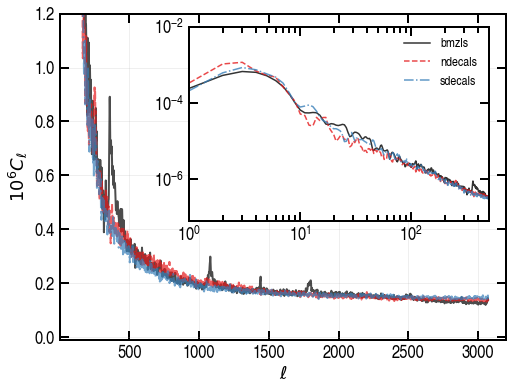

In [83]:
fg, ax = plt.subplots(figsize=(8, 6))
ax1 = fg.add_axes([0.35, 0.4, 0.52, 0.45])


for n, cl_i in cl_data.items():
    ax.plot(1.0e6*cl_i['cl_gg']['cl'], alpha=0.7, label=n, lw=2)
    ax1.plot(cl_i['cl_gg']['cl'], alpha=0.8, label=n)

    
ax1.legend(loc='upper right')
ax.grid(lw=1, alpha=0.2, which='both')
ax1.set(xlim=(1., 500.), ylim=(8.0e-8, 1.0e-2), xscale='log', yscale='log')
ax.set(xlim=(1, 3200), ylim=(-1.0e-2, 1.2), ylabel=r'$10^{6}C_{\ell}$', xlabel=r'$\ell$')

fg.savefig('cl_dr9elg.pdf', bbox_inches='tight')

In [78]:
def loadcl(filename):
    c_ = np.load(filename, allow_pickle=True)
    return np.concatenate(c_.flatten())

cl_wlin = {}
for reg in ['bmzls', 'ndecals', 'sdecals']:
    cl_wlin[reg] = loadcl(f'/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linear/windows/cell_{reg}.npy')

In [79]:
cl_wnn = {}
for reg in ['bmzls', 'ndecals', 'sdecals']:
    cl_wnn[reg] = loadcl(f'/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnn/windows/cell_{reg}.npy')

In [80]:
from matplotlib.gridspec import GridSpec

'NimbusSansNarrow-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusSansNarrow-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


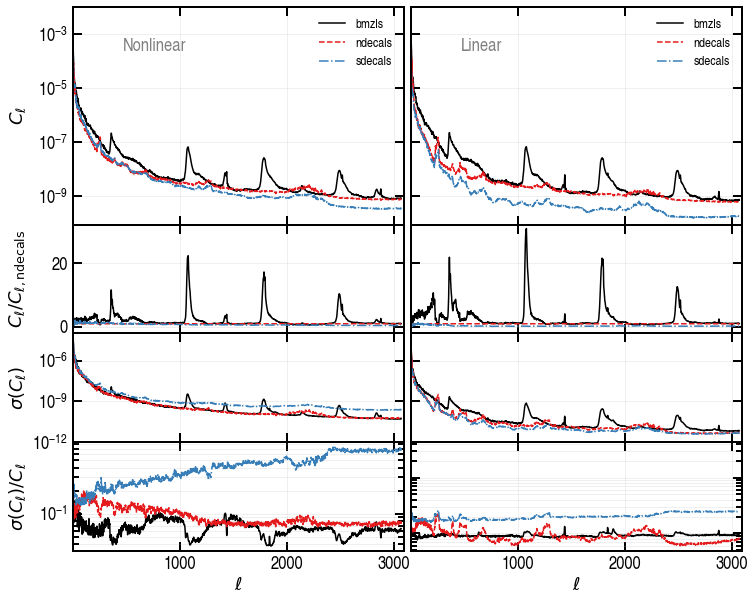

In [81]:
def add_plot(ax1, ax3, ax5, ax7, nb_winds, text=''):
    
    mk = ['^', 'o', 's']
    colors = ['C0', 'C1', 'C2']
    cl_ndec = np.mean(nb_winds['ndecals'], axis=0)
    
    for i, n_i in enumerate(['bmzls','ndecals', 'sdecals']):
        
        cl_mean = np.mean(nb_winds[n_i], axis=0)
        cl_std  = np.std(nb_winds[n_i], axis=0)
        #for ng_j in nb_winds[n_i]:    
        #    ax.plot(ng_j, color=colors[i], 
        #            ls='-', lw=1, alpha=0.1, zorder=-10)
            
        ax1.plot(cl_mean, color=colors[i], label=n_i)
        ax3.plot(cl_mean/cl_ndec, color=colors[i])
        ax5.plot(cl_std, color=colors[i])
        ax7.plot(cl_std/cl_mean, color=colors[i])
    

    ax1.legend(loc='upper right')
    ax1.set(yscale='log', xlim=(1.0, 3100), ylim=(9.0e-11, 1.0e-2))
    ax3.set(xlim=(1.0, 3100), xlabel=r'$\ell$', ylim=(-2, 32.0))
    #     ax3.set_yscale('symlog', linthresh=10)
    ax5.set(xlim=(1.0, 3100), yscale='log', ylim=(1.0e-12, 1.0e-4))    
    ax7.set(xlabel=r'$\ell$', xlim=(1.0, 3100.), yscale='log')
    
    for ax in [ax1, ax3, ax5, ax7]:
        ax.grid(lw=1, alpha=0.2, which='both')
    ax1.text(0.15, 0.8, text, color='grey', transform=ax1.transAxes)
    

    
#fg, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True, sharex=True)
#fg.subplots_adjust(wspace=0.0)
fig = plt.figure(figsize=(12, 10), constrained_layout=False)
gs = GridSpec(5, 2, figure=fig)

ax1 = fig.add_subplot(gs[:2, 0])
ax2 = fig.add_subplot(gs[:2, 1])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[2, 1])
ax5 = fig.add_subplot(gs[3, 0])
ax6 = fig.add_subplot(gs[3, 1])
ax7 = fig.add_subplot(gs[4, 0])
ax8 = fig.add_subplot(gs[4, 1])


for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.tick_params(labelbottom=False)
for ax in [ax2, ax4, ax6, ax8]:
    ax.tick_params(labelleft=False)
    

fig.subplots_adjust(hspace=0.0, wspace=0.02)

add_plot(ax1, ax3, ax5, ax7, cl_wnn, 'Nonlinear')
add_plot(ax2, ax4, ax6, ax8, cl_wlin, 'Linear')

ax1.set_ylabel(r'$C_{\ell}$')
ax3.set_ylabel(r'$C_{\ell}/C_{\ell, {\rm ndecals}}$')
ax5.set_ylabel(r'$\sigma(C_{\ell})$')
ax7.set_ylabel(r'$\sigma(C_{\ell})/C_{\ell}$')

fig.align_labels()
fig.savefig('cl_windows.pdf', bbox_inches='tight', dpi=300)

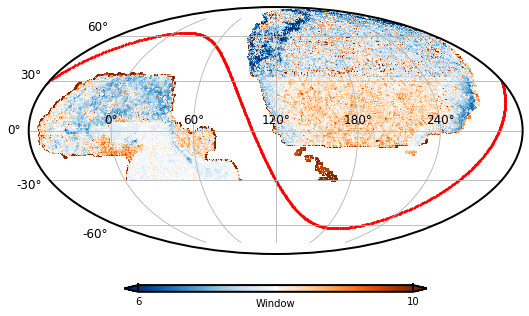

In [17]:
mollview(d, 6, 10, 'Window', galaxy=True, colorbar=True, cmap=mycolor())